In [1]:
import torch
import copy
import math
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [24]:
context_len = 8

X, Y = [], []
random.shuffle(words)

for w in words:  
    context = [0] * context_len
    for char in w + '.':
        X.append(context)
        Y.append(stoi[char])  
        context = context[1:] + [stoi[char]]
        
X, Y = torch.tensor(X), torch.tensor(Y)

n1, n2 = int(len(X)*0.8), int(len(X)*0.9)
Xtr, Ytr = X[:n1], Y[:n1]
Xval, Yval = X[n1:n2], Y[n1:n2]
Xtest, Ytest = X[n2:], Y[n2:]

In [26]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> a
......da --> l
.....dal --> a
....dala --> l
...dalal --> .
........ --> j
.......j --> a
......ja --> s
.....jas --> p
....jasp --> e
...jaspe --> n
..jaspen --> .
........ --> e
.......e --> l
......el --> a
.....ela --> y
....elay --> a
...elaya --> h
..elayah --> .


In [27]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers maintained with momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [28]:
# defining network
vocab_size = len(itos)
n_embed = 10
n_hidden = 200

model = Sequential([Embedding(vocab_size, n_embed), Flatten(), Linear(n_embed * context_len, 
        n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size)])

with torch.no_grad():
    # reduce confidence of last layer (get closer to uniform)
    model.layers[-1].weight *= 0.1
    
    # apply gain to the rest of the layers (keep activations from fully saturating)
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
    
# gather all parameters and calculate total number
parameters = model.parameters()
print(f"{sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True

22097 parameters


In [29]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2852
  10000/ 200000: 2.1648
  20000/ 200000: 1.8821
  30000/ 200000: 2.1940
  40000/ 200000: 2.0555
  50000/ 200000: 2.2768
  60000/ 200000: 2.2990
  70000/ 200000: 2.1235
  80000/ 200000: 2.2127
  90000/ 200000: 2.4183
 100000/ 200000: 2.3288
 110000/ 200000: 2.3115
 120000/ 200000: 2.2146
 130000/ 200000: 1.9069
 140000/ 200000: 2.1772
 150000/ 200000: 1.4597
 160000/ 200000: 2.4423
 170000/ 200000: 1.5386
 180000/ 200000: 1.9629
 190000/ 200000: 2.2351


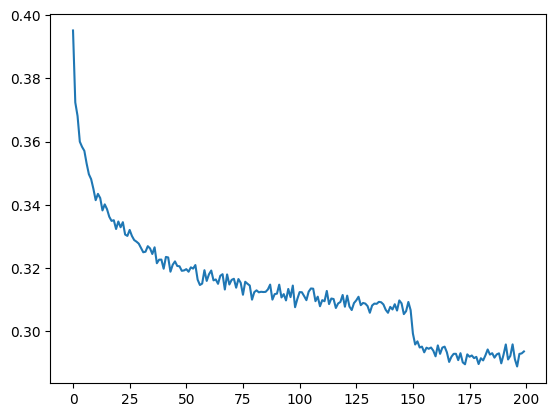

In [30]:
smooth_loss = torch.tensor(lossi).view(-1, 1000).mean(dim=1)
plt.plot(smooth_loss)

In [31]:
for layer in model.layers:
    layer.training = False

In [32]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.930120825767517
val 2.0078670978546143


In [33]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * context_len # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kahaya.
brenna.
lexia.
rahrelen.
brencer.
noa.
emmikae.
shra.
dubr.
nyenud.
anafhisya.
sylahaie.
anai.
korie.
kessady.
khyirn.
meliana.
aneem.
brayley.
amaira.
